<a href="https://colab.research.google.com/github/JacobyNevada/ds_belhard/blob/main/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
from google.colab import drive
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Загрузка файла
def data_loading(file_link):
  drive.mount('/content/drive')
  file_path = f"/content/drive/{file_link}"

  # Загрузка CSV файла
  dataset = pd.read_csv(file_path)
  return dataset

In [40]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder

def data_scaling(df):
  # Определяем группы признаков
  numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
  categorical_features = ["Month", "VisitorType"]
  boolean_features = ["Weekend", "Revenue"]

  # Убираем категориальные и булевые из числовых
  for col in categorical_features + boolean_features:
      if col in numeric_features:
          numeric_features.remove(col)

  # Масштабируем числовые признаки
  scaler = RobustScaler()
  df_numeric = pd.DataFrame(scaler.fit_transform(df[numeric_features]),
                            columns=numeric_features)

  # OneHotEncoder для категориальных
  ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
  df_categorical = pd.DataFrame(ohe.fit_transform(df[categorical_features]),
                                columns=ohe.get_feature_names_out(categorical_features))

  # Булевые переводим в 0/1
  df_boolean = df[boolean_features].astype(int)

  # Склеиваем всё вместе
  df_final = pd.concat([df_numeric, df_categorical, df_boolean], axis=1)

  return df_final

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def data_distribution_visualising(df):
    num_cols = df.select_dtypes(include='number').columns
    cat_cols = df.select_dtypes(exclude='number').columns

    # ----------------------
    # Фигура 1: гистограммы + KDE для числовых
    if len(num_cols) > 0:
        n_cols = 4
        n_rows = math.ceil(len(num_cols) / n_cols)
        plt.figure(figsize=(n_cols*4, n_rows*3))

        for i, col in enumerate(num_cols, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.histplot(df[col], bins=20, kde=True)
            plt.title(f'{col} (Hist)')

        plt.suptitle('Гистограммы + KDE числовых столбцов', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

    # ----------------------
    # Фигура 2: boxplot числовых
    if len(num_cols) > 0:
        n_cols = 4
        n_rows = math.ceil(len(num_cols) / n_cols)
        plt.figure(figsize=(n_cols*4, n_rows*3))

        for i, col in enumerate(num_cols, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.boxplot(x=df[col])
            plt.title(f'{col} (Box)')

        plt.suptitle('Boxplot числовых столбцов', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

    # ----------------------
    # Фигура 3: столбчатые диаграммы для категориальных
    if len(cat_cols) > 0:
        n_cols = 4
        n_rows = math.ceil(len(cat_cols) / n_cols)
        plt.figure(figsize=(n_cols*4, n_rows*3))

        for i, col in enumerate(cat_cols, 1):
            plt.subplot(n_rows, n_cols, i)
            counts = df[col].value_counts()
            sns.countplot(x=col, data=df, order=counts.index)
            plt.xticks(rotation=45)
            plt.title(f'{col} (Count)')

        plt.suptitle('Частоты категориальных столбцов', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# -------------------------
# Функция балансировки
def balance_data(X_train, y_train, method='SMOTE'):
    if method == 'SMOTE':
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        return X_res, y_res
    else:
        # Можно добавить другие методы (RandomOverSampler, Undersampler)
        return X_train, y_train

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def gradient_boosting_classifier(df, threshold=0.5, balance=False):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']

  # Разделение на train/test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  # Балансировка train
  if balance:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  # Модель Gradient Boosting
  gb_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
  gb_classifier.fit(X_train, y_train)

  # Предсказание вероятностей для класса 1
  y_proba = gb_classifier.predict_proba(X_test)[:, 1]

  # Применяем заданный threshold
  y_pred = (y_proba >= threshold).astype(int)

  # Отчёт
  print(f"\nGradient Boosting (balance={balance}, threshold={threshold})")
  print(classification_report(y_test, y_pred))

  # Confusion matrix для наглядности
  cm = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:\n", cm)

In [51]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [62]:
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def catboost_classifier(df, threshold=0.5, balance=False):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']

  # Разделение данных на обучающую и тестовую выборки
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Балансировка train
  if balance:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  # Модель CatBoost
  cb_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)
  cb_classifier.fit(X_train, y_train)

  # Предсказание вероятностей для класса 1
  y_proba = cb_classifier.predict_proba(X_test)[:, 1]

  # Применяем заданный threshold
  y_pred = (y_proba >= threshold).astype(int)

  # Отчёт
  print(f"\nCatBoost (balance={balance}, threshold={threshold})")
  print(classification_report(y_test, y_pred))

  # Confusion matrix для наглядности
  cm = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:\n", cm)

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

def knn_classifier(df, threshold=0.5, balance=False, n_neighbors=5):
    X = df.drop(columns=['Revenue'])
    y = df['Revenue']

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Балансировка train
    if balance:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Модель KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Предсказание вероятностей для класса 1
    y_proba = knn.predict_proba(X_test)[:, 1]

    # Применяем заданный threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Отчёт
    print(f"\nKNN (balance={balance}, threshold={threshold}, k={n_neighbors})")
    print(classification_report(y_test, y_pred))

    # Confusion matrix для наглядности
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

In [91]:
from sklearn.metrics import f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier

def find_best_threshold(df, balance=False, knn_neighbors=5):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']

  # Разделение на train/test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  # Балансировка train
  if balance:
      smote = SMOTE(random_state=42)
      X_train, y_train = smote.fit_resample(X_train, y_train)

  classifiers = {
      "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
      "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
      "KNN": KNeighborsClassifier(n_neighbors=knn_neighbors),
      "Random Forest":RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
      "Logistic Regression":LogisticRegression(solver="saga", max_iter=5000, C=10, random_state=42)
  }

  results = {}

  for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Проверяем thresholds от 0.0 до 1.0
    thresholds = np.arange(0.0, 1.01, 0.01)
    f1_scores = []

    for t in thresholds:
      y_pred = (y_proba >= t).astype(int)
      f1_scores.append(f1_score(y_test, y_pred))

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    results[name] = {"best_threshold": best_threshold, "best_f1": best_f1}

    print(f"{name} (balance={balance}) - Best threshold: {best_threshold:.2f}, F1-score: {best_f1:.3f}")

  return results

In [75]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def find_best_k(df):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']
  best_k = 0
  best_score = 0
  k_range=range(1, 51)
  cv_folds=5

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='f1')
    mean_score = np.mean(scores)

    if mean_score > best_score:
      best_score = mean_score
      best_k = k

  print(f"Лучшее k: {best_k}, F1-score (cv): {best_score:.3f}")
  return best_k

In [81]:
# Ансамбли моделей
# Пример с использованием RandomForest (случайный лес — один из методов Bagging):

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def random_forest_classifier(df, threshold=0.5, balance=False):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']

  # Разделение на train/test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  # Балансировка train
  if balance:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  # Модель KNN
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  # Предсказание вероятностей для класса 1
  y_proba = rf.predict_proba(X_test)[:, 1]

  # Применяем заданный threshold
  y_pred = (y_proba >= threshold).astype(int)

  # Отчёт
  print(f"\nRandom Forest (balance={balance}, threshold={threshold})")
  print(classification_report(y_test, y_pred))

  # Confusion matrix для наглядности
  cm = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:\n", cm)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

def logistic_regression_classifier(df, threshold=0.5, balance=False):
  X = df.drop(columns=['Revenue'])
  y = df['Revenue']

  # Разделение на train/test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  # Балансировка train
  if balance:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  # Модель Logistic Regression
  lr = LogisticRegression(solver="saga", max_iter=5000, C=10, random_state=42)
  lr.fit(X_train, y_train)

  # Предсказание вероятностей для класса 1
  y_proba = lr.predict_proba(X_test)[:, 1]

  # Подбор порога, если нужно
  if threshold == 'auto':
    thresholds = np.arange(0.0, 1.01, 0.01)
    f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    threshold = thresholds[best_idx]
    print(f"Optimal threshold: {threshold:.2f}, F1-score: {f1_scores[best_idx]:.3f}")

  # Применяем threshold
  y_pred = (y_proba >= threshold).astype(int)

  # Отчёт
  print(f"\nLogistic Regression (balance={balance}, threshold={threshold})")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               

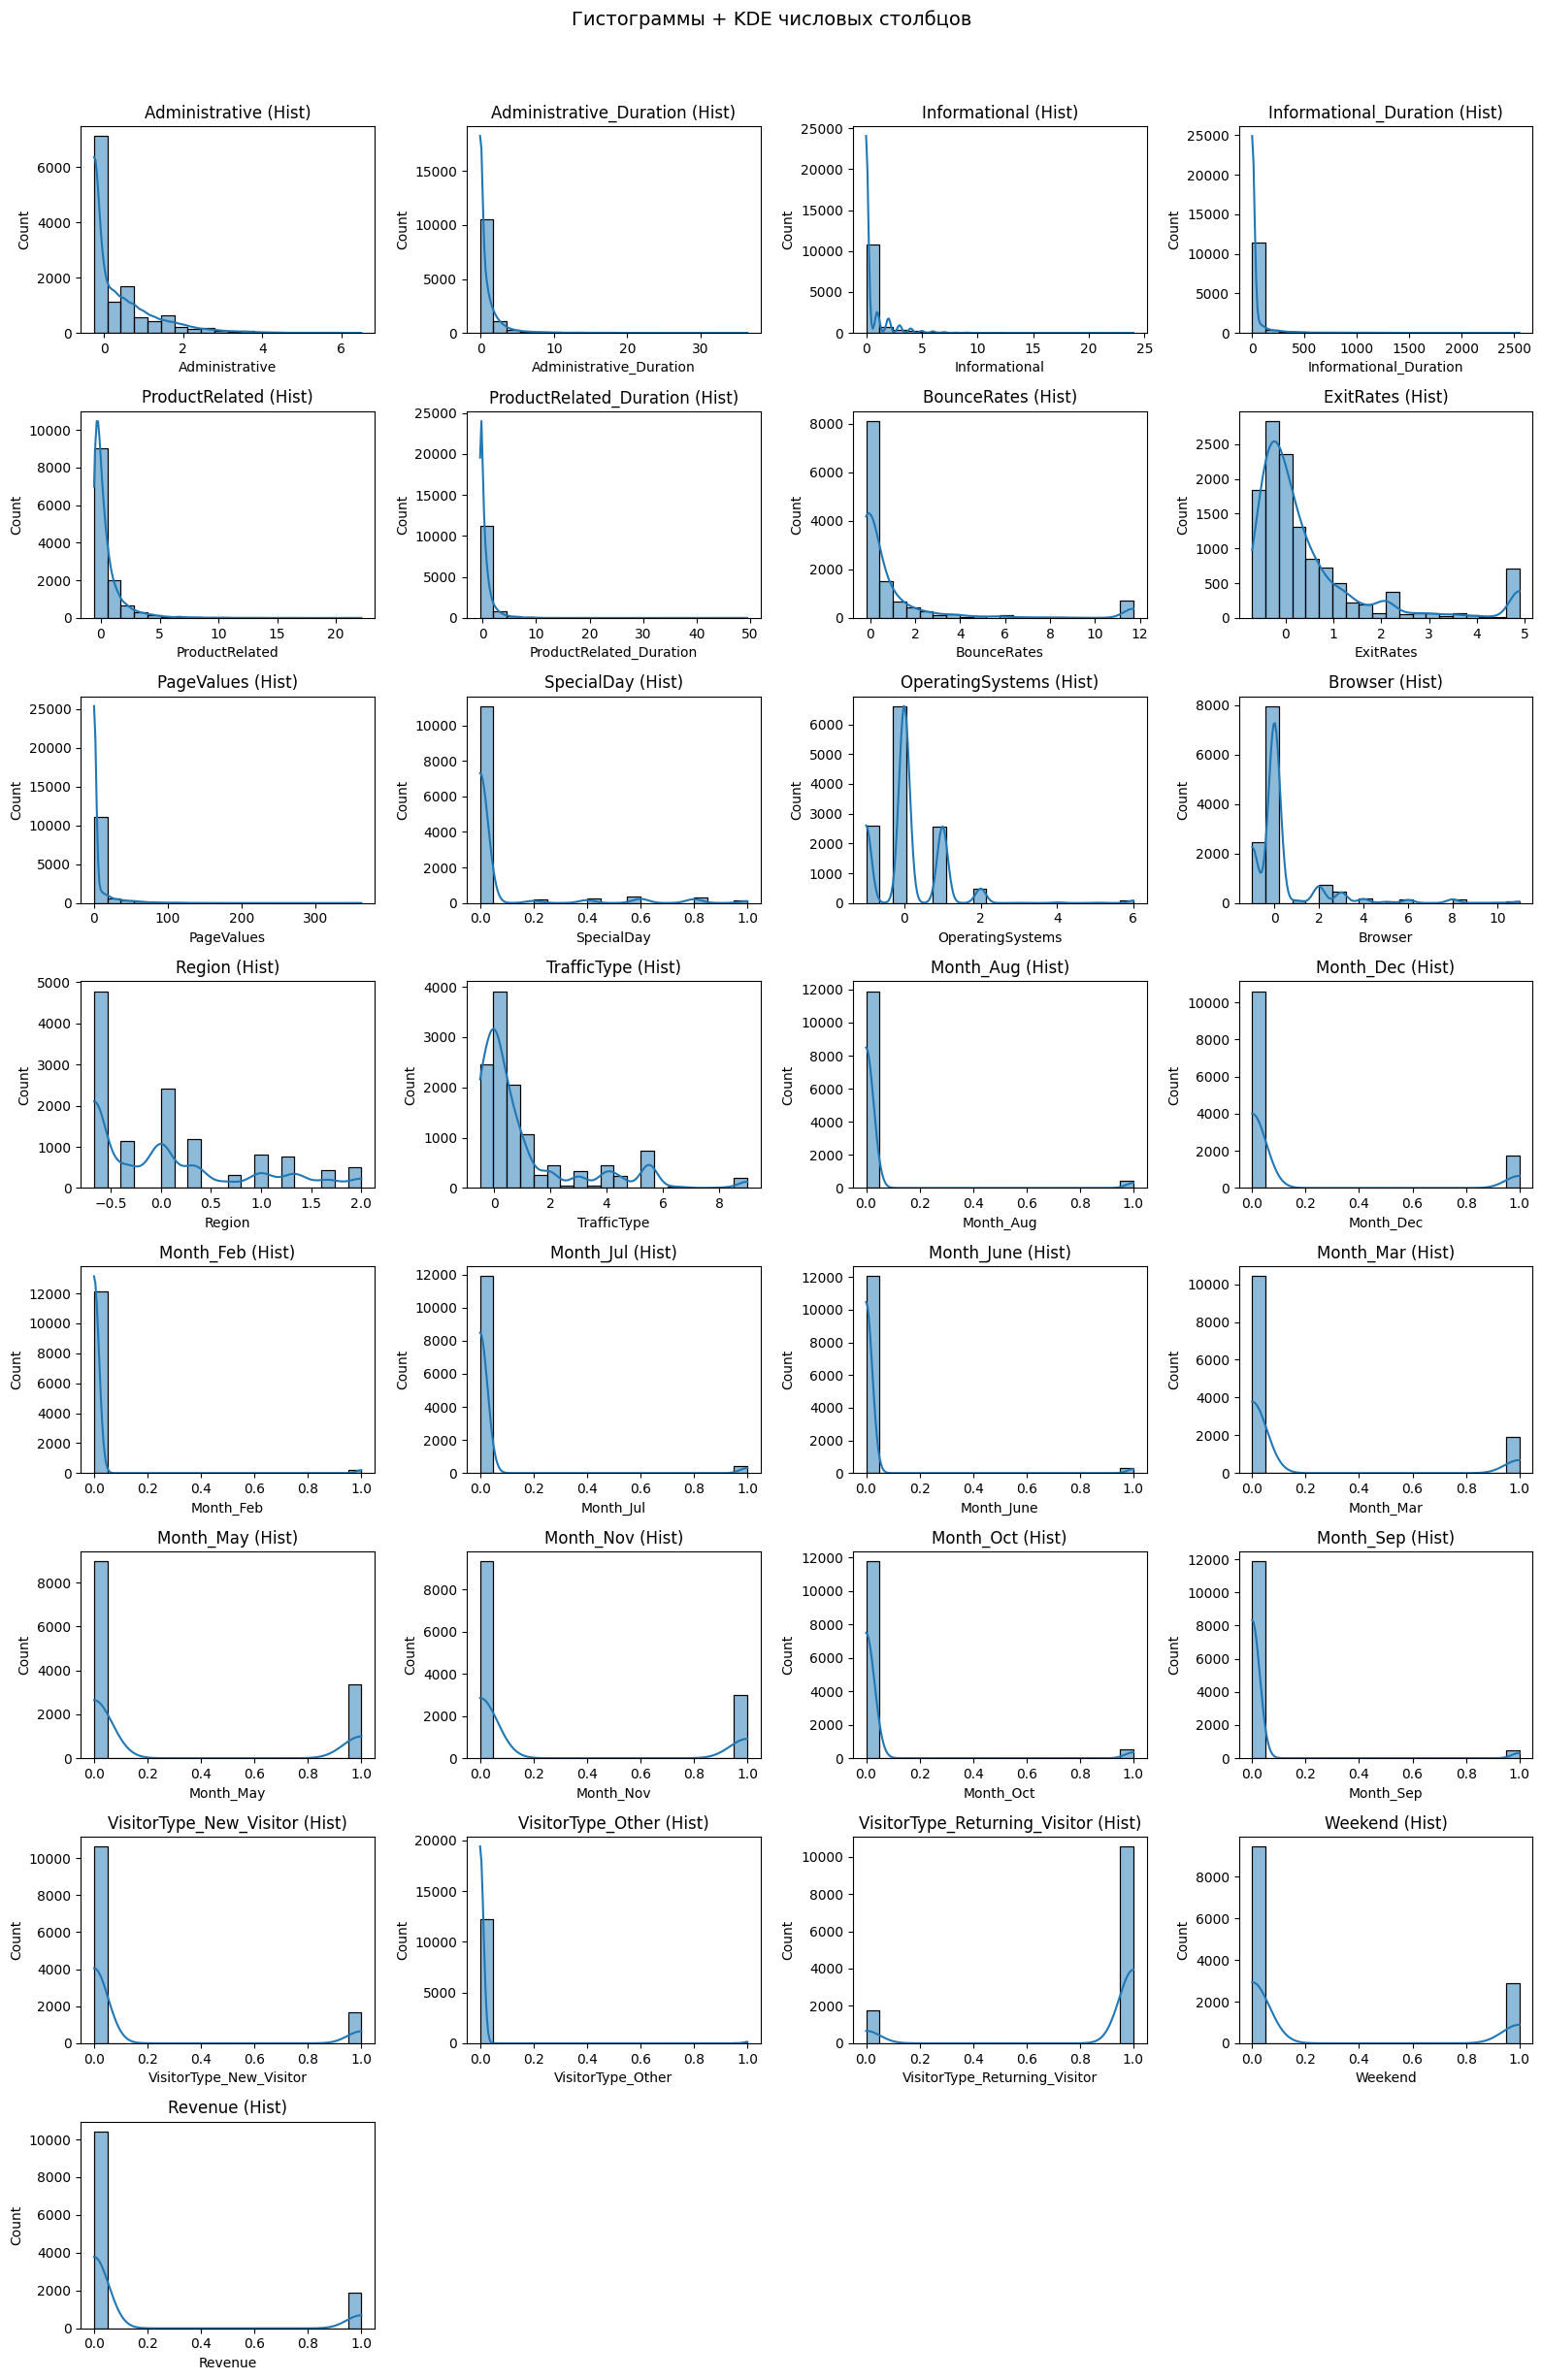

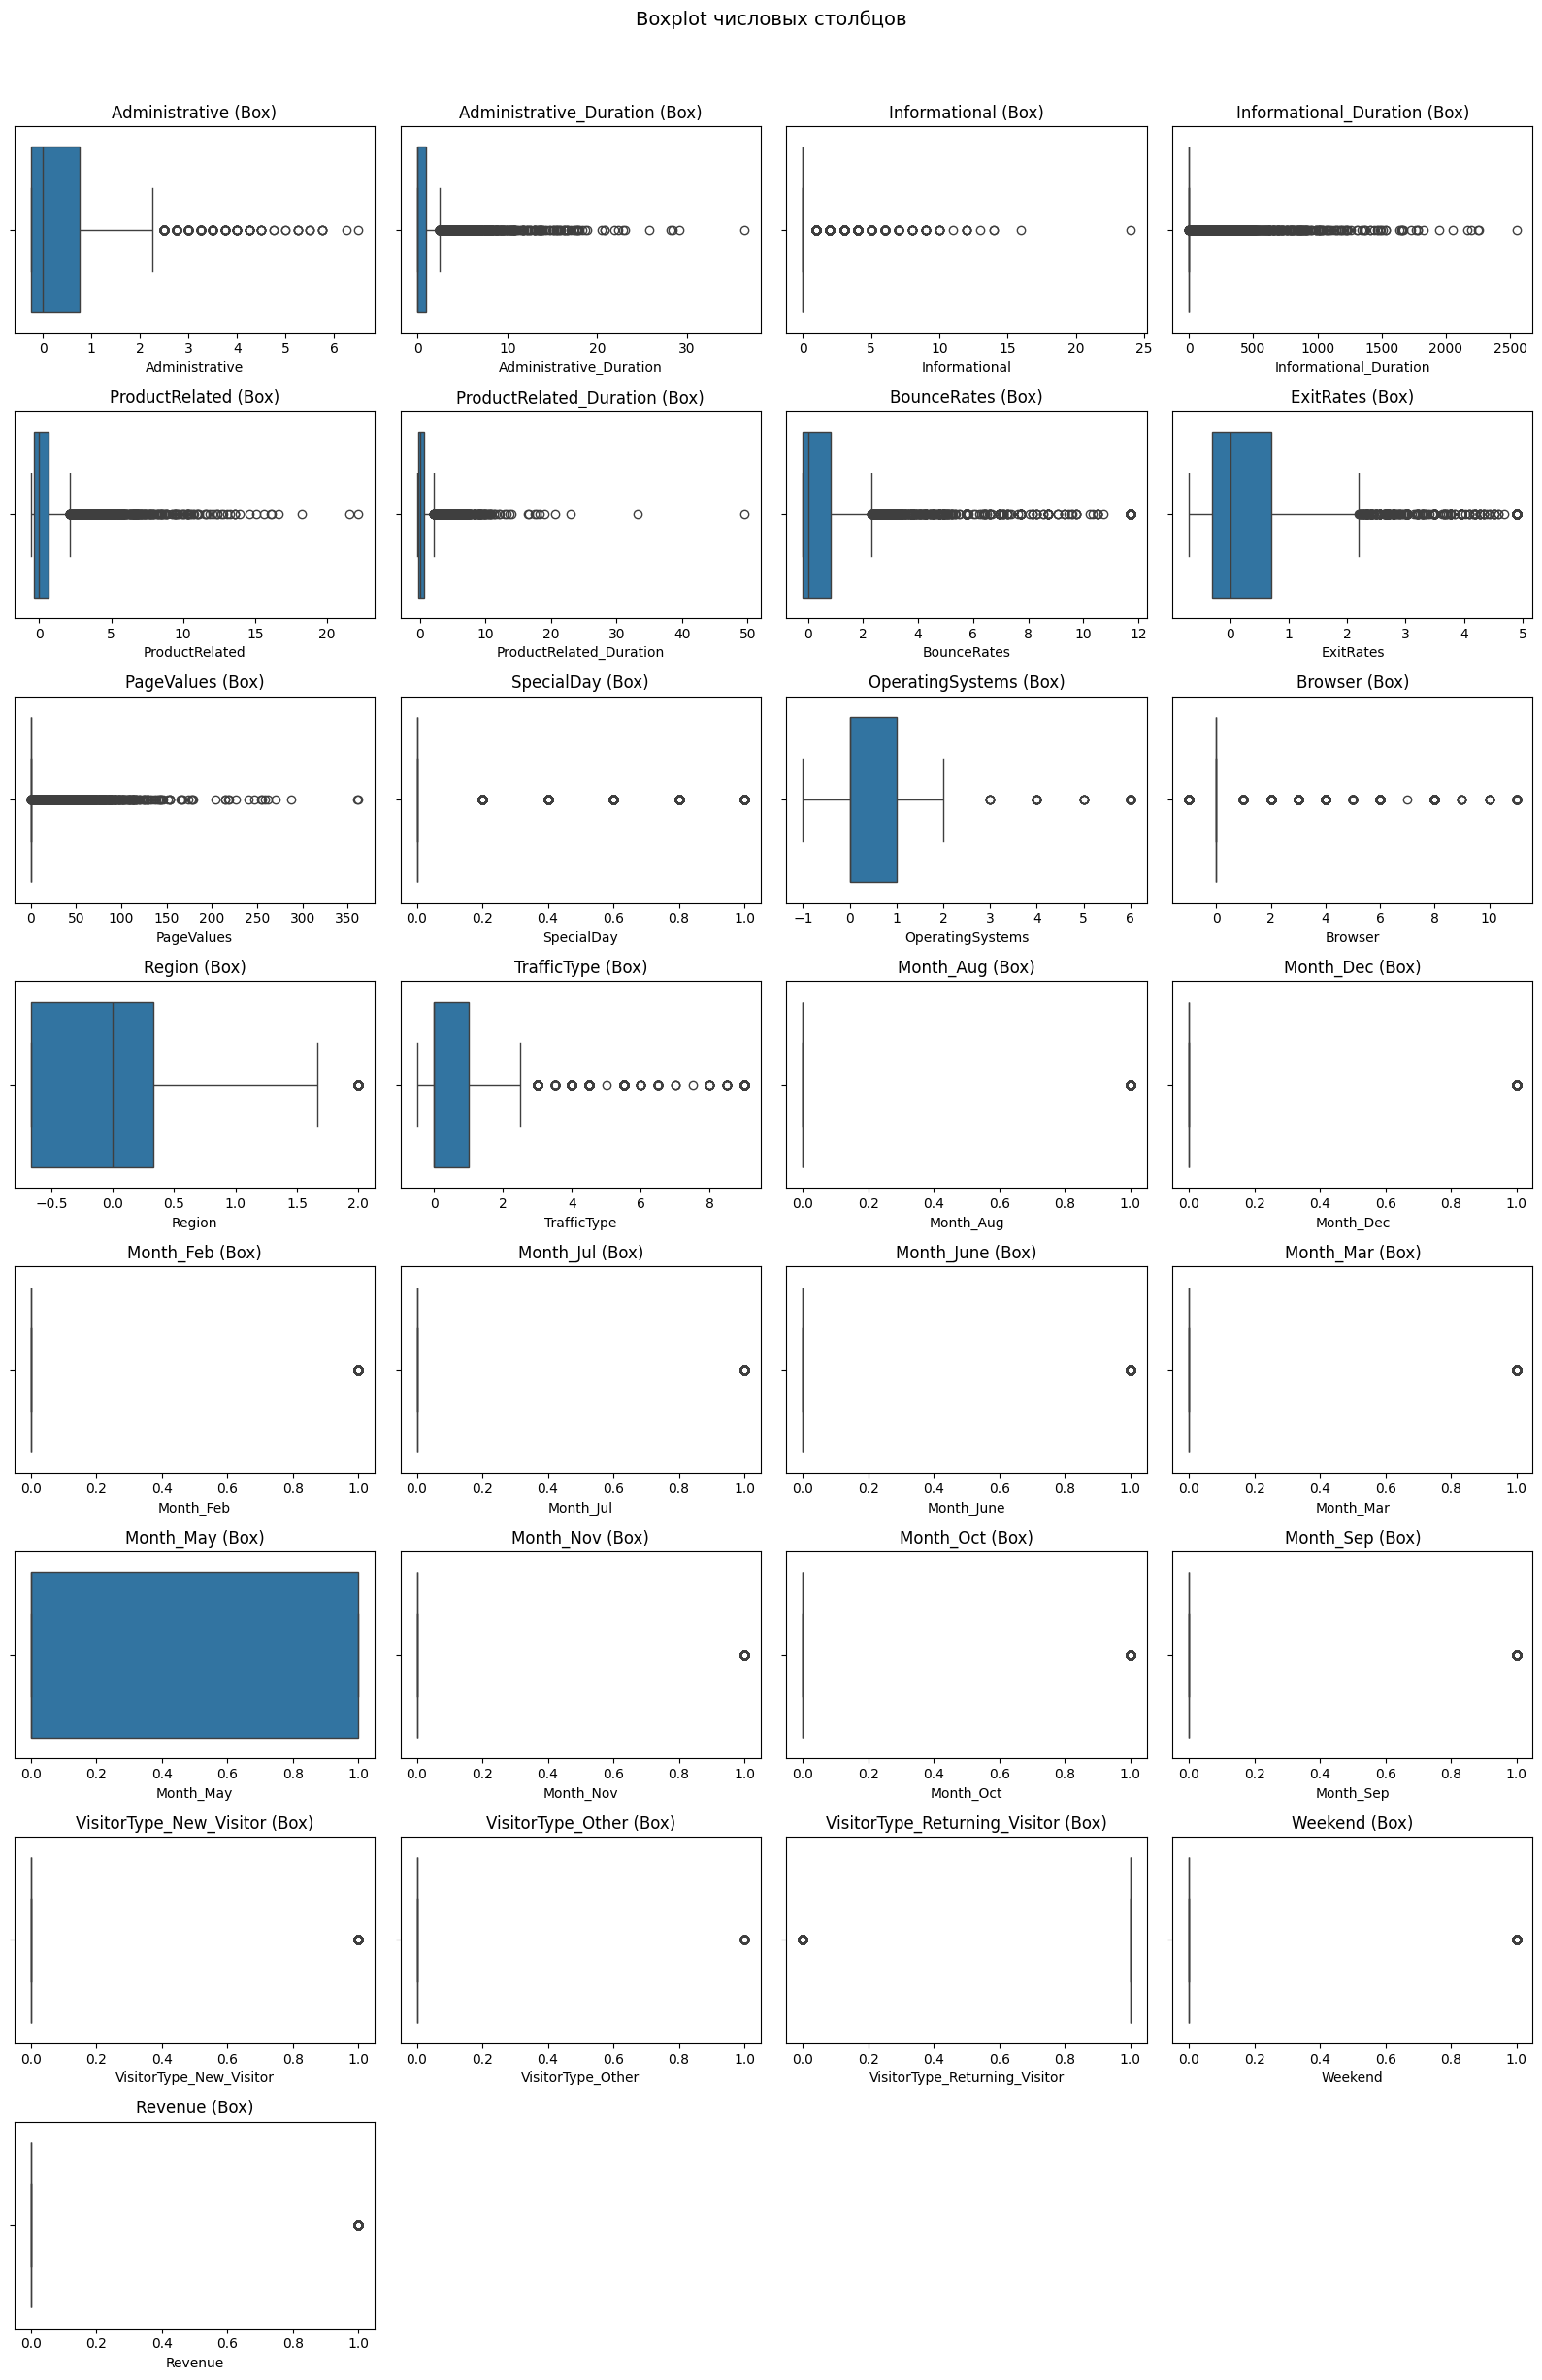

Лучшее k: 49, F1-score (cv): 0.605
Gradient Boosting (balance=True) - Best threshold: 0.45, F1-score: 0.666
CatBoost (balance=True) - Best threshold: 0.42, F1-score: 0.664
KNN (balance=True) - Best threshold: 0.74, F1-score: 0.628
Random Forest (balance=True) - Best threshold: 0.45, F1-score: 0.662


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression (balance=True) - Best threshold: 0.53, F1-score: 0.639

Gradient Boosting (balance=False, threshold=0.5)
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3127
           1       0.71      0.58      0.64       572

    accuracy                           0.90      3699
   macro avg       0.82      0.77      0.79      3699
weighted avg       0.89      0.90      0.89      3699

Confusion Matrix:
 [[2988  139]
 [ 239  333]]

Gradient Boosting (balance=True, threshold=0.45)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3127
           1       0.62      0.71      0.67       572

    accuracy                           0.89      3699
   macro avg       0.78      0.82      0.80      3699
weighted avg       0.90      0.89      0.89      3699

Confusion Matrix:
 [[2881  246]
 [ 164  408]]

CatBoost (balance=False, threshold=0.5)
              precision    recall  f1-

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# https://www.kaggle.com/datasets/henrysue/online-shoppers-intention
file_link = 'MyDrive/Colab Notebooks/hw4/online_shoppers_intention.csv'
df = data_loading(file_link)
print(df)
#data_distribution_visualising(df)

# Стандартизация данных
df_scale = data_scaling(df)
print(df_scale)
data_distribution_visualising(df_scale)


# Находим лучший k для knn
find_best_k(df_scale)

# Плохо распознается класс 1, подбираем оптимальный threshold
find_best_threshold(df_scale, balance=True, knn_neighbors=49)

gradient_boosting_classifier(df_scale)
gradient_boosting_classifier(df_scale, threshold=0.45, balance=True)

catboost_classifier(df_scale)
catboost_classifier(df_scale, threshold=0.42, balance=True)

knn_classifier(df_scale)
knn_classifier(df_scale, threshold=0.74, balance=True, n_neighbors=49)

random_forest_classifier(df_scale)
random_forest_classifier(df_scale, threshold=0.45, balance=True)

logistic_regression_classifier(df_scale)
logistic_regression_classifier(df_scale, threshold=0.53, balance=True)

В этом датасете большой перекос данных (класс 0: 10422, класс 1: 1908).

**Самый удачный вариант получился с классификатором CatBoos**t, с предварительной балансировкой тестовых данных, с подбором threshold.